# NI-SCR: Semestral project
## Heartbeat anomaly detection
### Resources:
- https://www.analyticsvidhya.com/blog/2022/01/complete-guide-to-anomaly-detection-with-autoencoders-using-tensorflow/
- https://www.tensorflow.org/tutorials/generative/autoencoder
- https://keras.io/examples/timeseries/timeseries_anomaly_detection/
- https://www.kaggle.com/code/aavigan/ecg-classification-using-pruneddtw/notebook
- https://medium.com/analytics-vidhya/anomaly-detection-in-cardio-dataset-using-deep-learning-technique-autoencoder-fd24ca9e5c69
- https://towardsdatascience.com/generating-images-with-autoencoders-77fd3a8dd368
- https://towardsdatascience.com/time-series-classification-using-dynamic-time-warping-61dcd9e143f6
https://towardsdatascience.com/dynamic-time-warping-3933f25fcdd

### Data:
- http://www.timeseriesclassification.com/description.php?Dataset=ECG5000
 - Description: https://www.physionet.org/content/ptbdb/1.0.0/

In [ ]:
!pip install dtaidistance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.4 MB 5.9 MB/s 


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math

import tensorflow as tf
from tensorflow.keras import layers, Sequential

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, mean_absolute_error, confusion_matrix
from sklearn.preprocessing import MinMaxScaler

from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis

## Data preprocessing and analysis
### Time Series Classification ECG5000 Dataset
The dataset can be accessed [here](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000), each of the ECG signals is segmented to contain exactly one heartbeat and interpolated to have a length of 140 units. There are two classes in this dataset 1 - normal rhytms / 0 - abnormal rhytms. The abnormal ECG signals are obtained from patients diagnosed with congestive heart failure.

The last column represents class so it will be renamed for easier access, and
afterwards we take a look at the value counts - the dataset looks pretty well balanced, which is good, but it has not been normalized yet, so that will need to be dealt with later.

In [ ]:
df = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
df.columns = range(0, df.shape[1])

df.rename(columns={df.shape[1] - 1: "class"}, inplace=True)
df

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,class
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4993,0.608558,-0.335651,-0.990948,-1.784153,-2.626145,-2.957065,-2.931897,-2.664816,-2.090137,-1.461841,...,1.757705,2.291923,2.704595,2.451519,2.017396,1.704358,1.688542,1.629593,1.342651,0.0
4994,-2.060402,-2.860116,-3.405074,-3.748719,-3.513561,-3.006545,-2.234850,-1.593270,-1.075279,-0.976047,...,1.388947,2.079675,2.433375,2.159484,1.819747,1.534767,1.696818,1.483832,1.047612,0.0
4995,-1.122969,-2.252925,-2.867628,-3.358605,-3.167849,-2.638360,-1.664162,-0.935655,-0.866953,-0.645363,...,-0.472419,-1.310147,-2.029521,-3.221294,-4.176790,-4.009720,-2.874136,-2.008369,-1.808334,0.0
4996,-0.547705,-1.889545,-2.839779,-3.457912,-3.929149,-3.966026,-3.492560,-2.695270,-1.849691,-1.374321,...,1.258419,1.907530,2.280888,1.895242,1.437702,1.193433,1.261335,1.150449,0.804932,0.0


In [ ]:
df['class'].value_counts()

1.0    2919
0.0    2079
Name: class, dtype: int64

In [ ]:
def plotStatECG(data, title, ax):
  lower_bound = data.mean(axis=0) - data.std(axis=0)
  upper_bound = data.mean(axis=0) + data.std(axis=0)

  ax.plot(np.arange(data.shape[1]), data.iloc[0], color='seagreen', label='Example heartbeat')

  ax.plot(np.arange(data.shape[1]), data.mean(axis=0), color='royalblue', label='Average heartbeat')
  ax.fill_between(np.arange(data.shape[1]), lower_bound, upper_bound, alpha=.3, color='royalblue', label='Standard deviation')

  ax.grid()
  ax.set_ylim([-5, 3])
  ax.legend()
  ax.set_title(title)

In [ ]:
def plotECG(data, title, ax):
  for _, row in data.head(5).iterrows():
    ax.plot(np.arange(data.shape[1]), row)

  ax.grid()
  ax.set_ylim([-5, 3])
  ax.set_title(title)

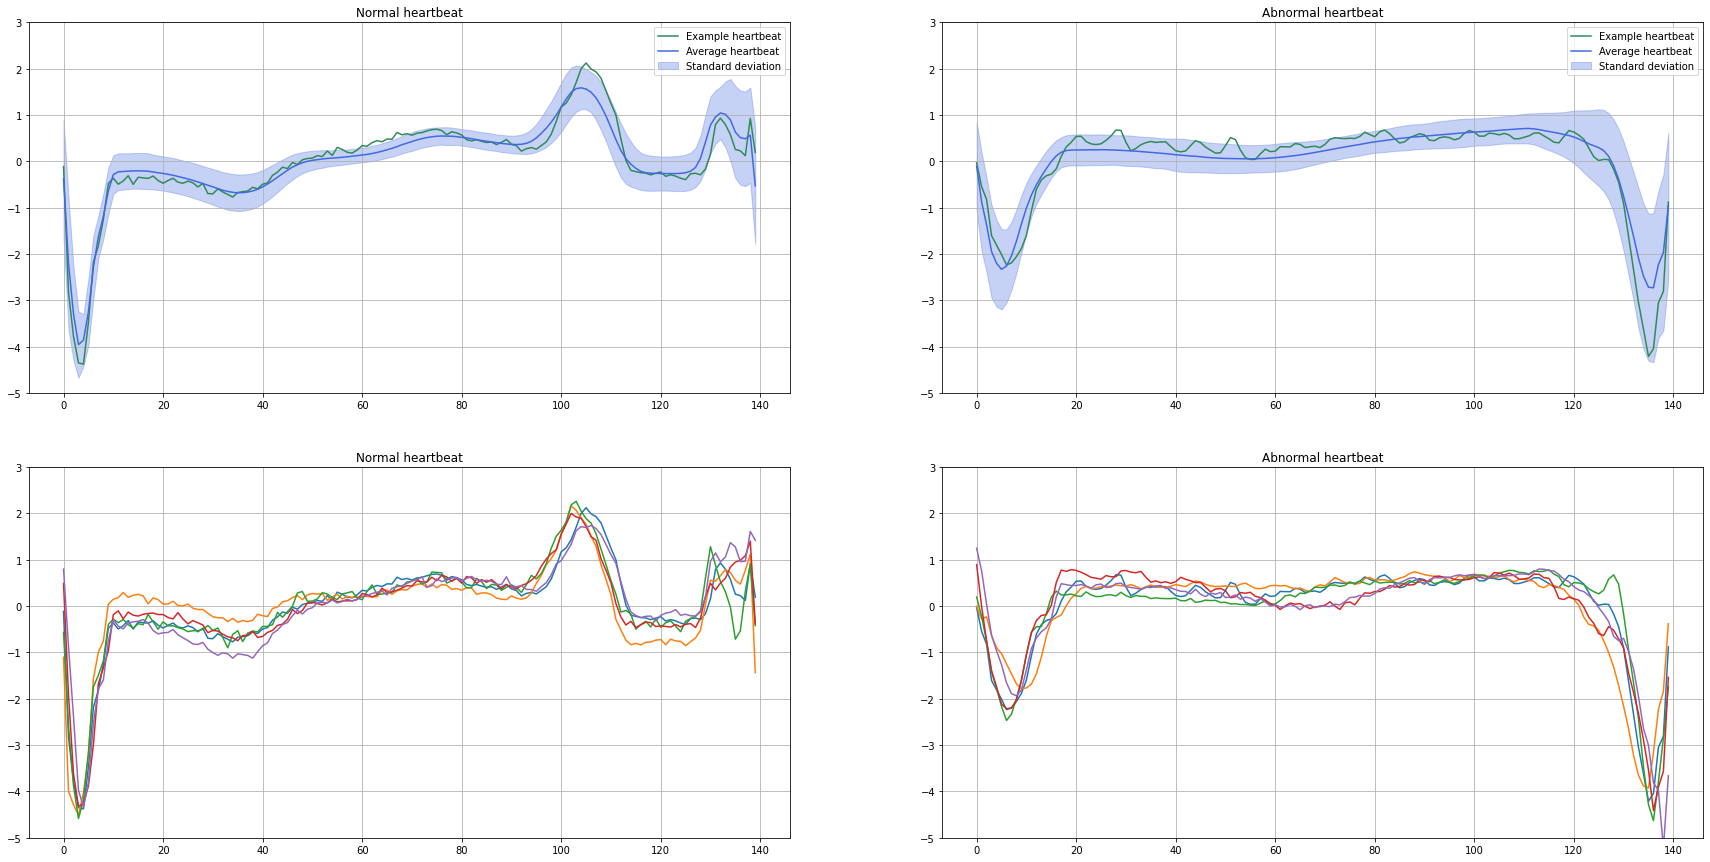

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 2, figsize=(30,15))

plotStatECG(df.loc[df['class'] == 1].drop('class', axis=1), 'Normal heartbeat', ax1[0])
plotStatECG(df.loc[df['class'] == 0].drop('class', axis=1), 'Abnormal heartbeat', ax1[1])

plotECG(df.loc[df['class'] == 1].drop('class', axis=1), 'Normal heartbeat', ax2[0])
plotECG(df.loc[df['class'] == 0].drop('class', axis=1), 'Abnormal heartbeat', ax2[1])

By loking at the plotted normal and abnormal heartbeat ECG's one can notice a few differences. It seems as though the normal heartbeats contain two distinct peaks, one strong at the very beginning and then a weaker one at the end. The signal between the peaks seems pretty stable with only little oscillation inbetween. On the other hand the abnormal heartbeats have a much weaker first peak, and then a strong second one. The oscillation overall seems much stronger than in the normal cases.

#### Train-test split

We need to split the data into a training and testing set, and afterwards normalize it, since in the analysis before we discovered that it has not yet been normalized.

In [ ]:
X = df.iloc[: , :-1].copy()
y = df.iloc[:,-1:].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

In [ ]:
# Scale the test and train data independently, based on train distribution
scaler = MinMaxScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train.values), columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test.values), columns=X_test.columns, index=X_test.index)

## Autoencoder model

An autoencoder is a model that is able to construct a latent space representation of input data, and then reconstruct it back. It consists of two separate parts, an encoder, which performs downsampling operation  and a decoder, which performs upsampling operation. Downsampling operation is implemented using dense layers with gradually decreasing size, while upsampling is implemented in an analogous way, only with increasing dense layer size. The reconstruction ability makes autoencoders suitable for use in anomaly detection tasks.

In [ ]:
autoencoder = Sequential (
    [
        # Encoder - performs upsampling
        layers.Dense(32, activation="relu", input_shape=(X_train.shape[1],)),
        layers.Dense(16, activation="relu"),
        layers.Dense(8, activation="relu"),

        # Decoder - performs downsampling
        layers.Dense(16, activation="relu"),
        layers.Dense(32, activation="relu"),
        layers.Dense(140, activation="sigmoid")
    ]
)

autoencoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                4512      
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dense_3 (Dense)             (None, 16)                144       
                                                                 
 dense_4 (Dense)             (None, 32)                544       
                                                                 
 dense_5 (Dense)             (None, 140)               4620      
                                                                 
Total params: 10,484
Trainable params: 10,484
Non-traina

#### Model training
The autoencoder will be trained using standard backpropagation on normal data only, so that the model can learn the distribution of a normal heartbeat. This way when we later provide the model with an abnormal heartbeat, distribution of which differs from a normal one, it will not be able to reconstruct it properly. The reconstruction error will then be used to identify normal and abnormal heartbeats, asuming that the autoencoder is able to reconstruct normal heartbeats more precisely than abnormal ones. Because of this we need to further split the train and test data into normal and abnormal.

In [ ]:
# Splits the y and X data to normal and abnormal, as needed for autoencoder training
def class_split(y_train, y_test, X_train, X_test):
  train_mask = np.array(y_train.astype(bool))
  test_mask = np.array(y_test.astype(bool))

  return X_train[train_mask], X_test[test_mask], X_train[np.invert(train_mask)], X_test[np.invert(test_mask)]

In [ ]:
X_train_normal, X_test_normal, X_train_abnormal, X_test_abnormal = class_split(y_train, y_test, X_train, X_test)

autoencoder.compile(optimizer='adam', loss='mae')
autoencoder.fit(X_train_normal, X_train_normal, epochs=50, batch_size=200, shuffle=True)

Epoch 1/50
12/12 [==============================] - 1s 4ms/step - loss: 0.1402
Epoch 2/50
12/12 [==============================] - 0s 3ms/step - loss: 0.1232
Epoch 3/50
12/12 [==============================] - 0s 3ms/step - loss: 0.1007
Epoch 4/50
12/12 [==============================] - 0s 3ms/step - loss: 0.0787
Epoch 5/50
12/12 [==============================] - 0s 6ms/step - loss: 0.0615
Epoch 6/50
12/12 [==============================] - 0s 4ms/step - loss: 0.0527
Epoch 7/50
12/12 [==============================] - 0s 10ms/step - loss: 0.0485
Epoch 8/50
12/12 [==============================] - 0s 6ms/step - loss: 0.0470
Epoch 9/50
12/12 [==============================] - 0s 5ms/step - loss: 0.0465
Epoch 10/50
12/12 [==============================] - 0s 7ms/step - loss: 0.0462
Epoch 11/50
12/12 [==============================] - 0s 5ms/step - loss: 0.0461
Epoch 12/50
12/12 [==============================] - 0s 5ms/step - loss: 0.0461
Epoch 13/50
12/12 [=============================

In [ ]:
reconstruct = autoencoder.predict(X_train_normal)
train_losses = mean_absolute_error(X_train_normal, reconstruct, multioutput='raw_values')

threshold = np.mean(train_losses) + np.std(train_losses)

print('MAE:       ' + str(np.mean(train_losses)))
print('Threshold: ' + str(threshold))

74/74 [==============================] - 1s 4ms/step
MAE:       0.028785093365028613
Threshold: 0.046915443634484175


#### Model evaluation
As mentioned above, the trained model should now be able to represent a normal heartbeat and be able to reconstruct it. Now we have to define a threshold which will separate the normal heartbeats from abnormal ones. The threshold, or in other words a tolerance for reconstruction error, is defined as mean average error across all training samples plus one standard deviation.

Having defined the threshold we will now be able to classify the testing samples simply by comparing their loss with the threshold value. For model evaluation we will use confusion matrix and F1 score, which takes into account both precision and recall.

In [ ]:
reconstruct = autoencoder(np.array(X_test))
test_losses = mean_absolute_error(np.transpose(X_test), np.transpose(reconstruct), multioutput='raw_values')

preds = np.where(test_losses > threshold, 0, 1)

In [ ]:
def plotConfusionMatrix(predict_test, y_test):
  cm = confusion_matrix(predict_test, y_test)
  df_cm = pd.DataFrame(cm, index = ['A', 'N'], columns = ['A', 'N'])

  plt.figure(figsize = (7,7))

  sns.set(font_scale=1.4)
  sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g', linewidths=4, cbar=False, cmap="crest")

  plt.show()

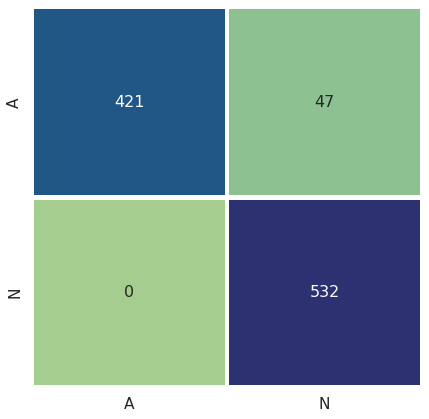

In [ ]:
plotConfusionMatrix(preds, y_test)

In [ ]:
print('F1 score: ' + str(f1_score(preds, np.array(y_test))))

F1 score: 0.9576957695769577


The model was able to detect all abnormal hearbeat samples, but incorrectly identified about 8% of normal samples, with the F1 score being 95%. Overall the model performance is very good, especially taking into account the fact that there was no actual parameter tuning. Playing around with the number of dense layers, latent space size, or number of epochs might give an even better result, but for now we will keep these parameters the same as this is not the main focus of this project.

We can take a look at one more threshold setting, to illustrate that in this case the threshold is a parameter which needs to be tuned as well. For example taking two standard deviations yields a different result - three abnormal heartbeats were incorrectly classified, but on the other hand the number of incorrectly classified normal heartbeats dropped by more than a half, and as a result the overall F1 score increased by almost 4% to a final score of 98%.

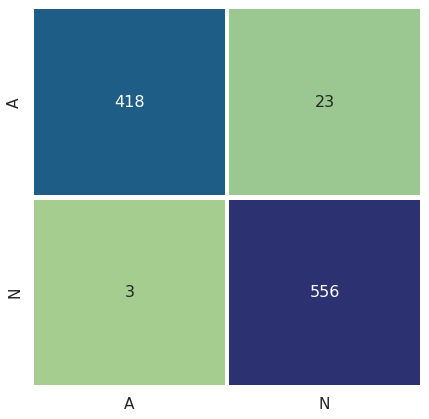

In [ ]:
threshold = np.mean(train_losses) + (2 * np.std(train_losses))

preds = np.where(test_losses > threshold, 0, 1)
plotConfusionMatrix(preds, y_test)

In [ ]:
print('F1 score: ' + str(f1_score(preds, np.array(y_test))))

F1 score: 0.9771528998242531


#### Reconstruction error visualization

Here is a visualization of reconstruction error for one abnormal and one normal sample. It is easily noticable that the reconstruction error is much greater for an abnormal heartbeat than for a normal one. One can also notice that the abnormal heartbeat reconstruction is very similar to an average normal heartbeat, distribution of which the autoencoder is familiar with.

In [ ]:
def plotReconstructionError(original, reconstruct, ax, title):
  # Inverse transform the data back from normalized values
  original_transform = scaler.inverse_transform(original)
  reconstruct_transform = scaler.inverse_transform(reconstruct)

  ax.plot(original_transform[0], color='red', label='Original')
  ax.plot(reconstruct_transform[0], color='royalblue', label='Reconstruction')
  ax.fill_between(np.arange(140), original_transform[0], reconstruct_transform[0], color='lightcoral', label='Error')

  ax.legend()
  ax.set_title(title)

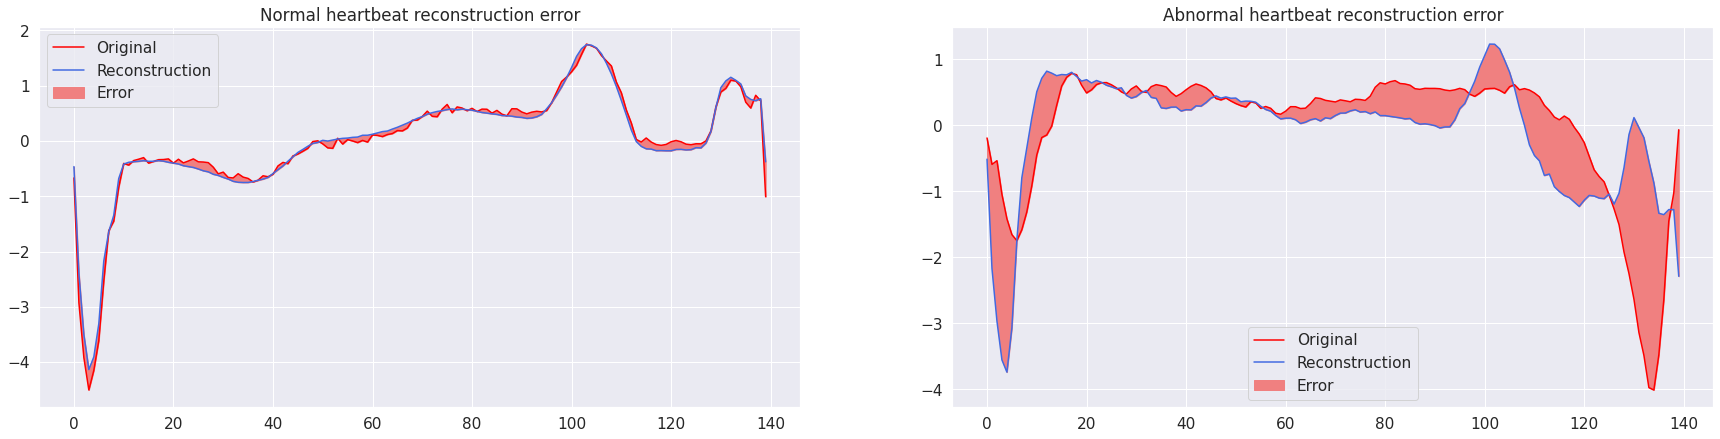

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30,7))

reconstruct_normal = autoencoder(np.array(X_test_normal))
plotReconstructionError(X_test_normal, reconstruct_normal, ax1, 'Normal heartbeat reconstruction error')

reconstruct_abnormal = autoencoder(np.array(X_test_abnormal))
plotReconstructionError(X_test_abnormal, reconstruct_abnormal, ax2, 'Abnormal heartbeat reconstruction error')

## Dynamic time warping (DTW)
Anomaly detection can also be performed by comparing the difference in terms of distance between two timeseries. For a target sample one can compute the distance from all normal and abnormal training samples separately, and then compare the two values, predicting the one with shorter distance. As a benchmark we can take simple euclidean distance between pairs of corresponding points and then compare the obtained results with a more complex distance measuring technique called dynamic time warping.

In dynamic time warping the indices are matched differently, and it is used primarily to align sequences of different lengths. Dynamic time warping looks for a mapping, which satisfies the following conditions.
- Every index from both first and second sequence must have at least one match
- The first point from the first sequence needs to be matched with the first point from the second one
- The last point from the first sequence needs to be matched with the last point from the second one
- The mapping needs to be ordered, meaning that there can be no crossed lines

The mapping also has to have a minimal cost, which is calculated as a sum of absolute differences across all matched index pairs. The product of dynamic time warping is a warping path, which defines an aligned pair of sequences, one is illustrated below.



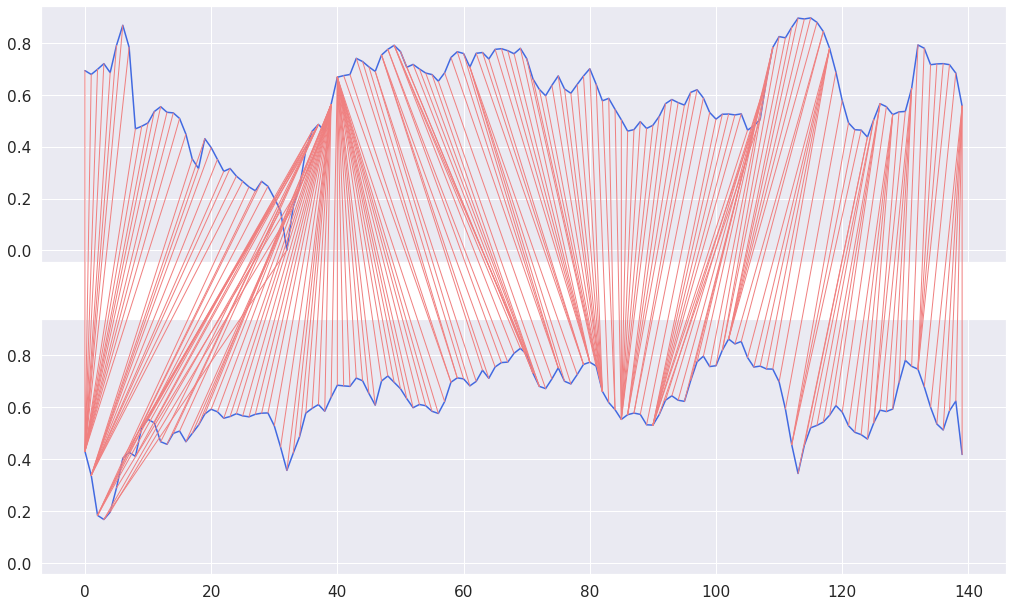

In [ ]:
path = dtw.warping_path(X_train_normal.iloc[0], X_train_normal.iloc[1])

fig, axs = dtwvis.plot_warping(X_train_normal.iloc[0], X_train_normal.iloc[1], path, warping_line_options={'color': 'lightcoral'}, series_line_options={'color': 'royalblue'})
fig.set_size_inches(16, 10)

### Euclidean distance predictions

One can see that measuring the distance of heartbeat singnals using simple Euclidean distance yields some pretty impressive results. The F1 score is approximately the same as for the results obtained usng an autoencoder, however the difference is in predicting abnormal heartbeats. While the autoencoder managed to predict all abnormal samples correctly, the predictions based on euclidean distance missed about 8%. Considering the medical setting, and severity of the patient's diagnosis (CHF), this can be seen as a somewhat dramatic difference.

In [ ]:
def predictEuclidean(sample):
  normal = X_train_normal.sub(sample.squeeze(), axis=1)
  normal['dist'] = normal.apply(np.linalg.norm, axis=1)

  abnormal = X_train_abnormal.sub(sample.squeeze(), axis=1)
  abnormal['dist'] = abnormal.apply(np.linalg.norm, axis=1)

  if normal["dist"].mean() < abnormal["dist"].mean():
    return 1

  return 0

In [ ]:
preds_euc = []

for _, row in X_test.iterrows():
  preds_euc.append(predictEuclidean(row))

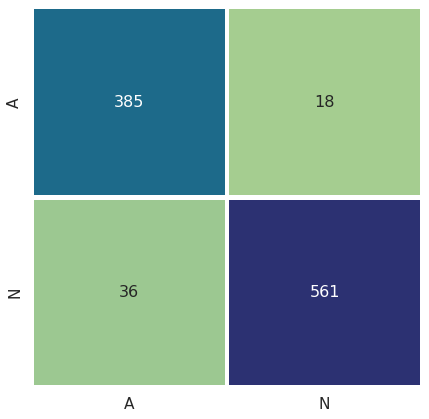

In [ ]:
plotConfusionMatrix(preds_euc, y_test)

In [ ]:
print('F1 score: ' + str(f1_score(preds_euc, np.array(y_test))))

F1 score: 0.9540816326530611


### Dynamic time warping predictions

First, I wanted to compare dynamic time warping distances from all testing samples to each of the training samples, but this would take ages. Calculating the distance from a single training sample to all of the testing samples takes about 3 minutes, therefore for all 1000 testing samples this would take about 50 hours. So I decided to compare the testing samples with an average normal or abnormal heartbeat and obtained the results which can be seen below. Again, the performance is pretty impressive, but the inability to predict abnormal samples correctly increased to about 12%.

Since this worsening in performance in comparison to Euclidean distance can be caused by only comparing with an average heartbeat, in the final part of this project I will try to predict the incorrectly predicted samples by comparing them with the whole dataset, and see if it makes any difference.

In [ ]:
# In dtw.distance, parameters are set to shorten the calculation, window - sets maximum shift between paired indices, use_pruning - stops calculation if returned values are greater than Euclidean distance
def predictDTW(sample, strategy='M'):
  normal_dist, abnormal_dist = [], []

  if strategy == 'A':
    for _, row in X_train_normal.iterrows():
      normal_dist.append(dtw.distance(sample, row, window=20, use_pruning='True'))

    for _, row in X_train_abnormal.iterrows():
      abnormal_dist.append(dtw.distance(sample, row, window=20, use_pruning='True'))
  else:
    normal_dist.append(dtw.distance(sample, X_train_normal.mean(axis=0)))

    abnormal_dist.append(dtw.distance(sample, X_train_abnormal.mean(axis=0)))

  if np.mean(normal_dist) < np.mean(abnormal_dist):
    return 1

  return 0

In [ ]:
preds_dtw = []

for _, row in X_test.iterrows():
  preds_dtw.append(predictDTW(row, 'M'))

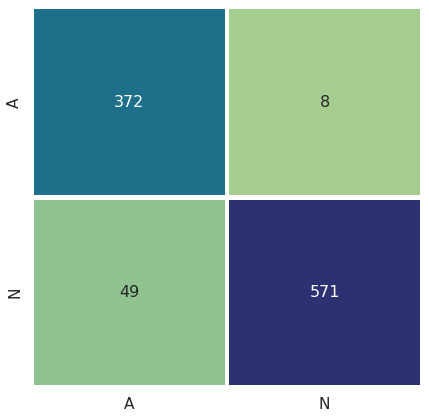

In [ ]:
plotConfusionMatrix(preds_dtw, y_test)

In [ ]:
print('F1 score: ' + str(f1_score(preds_dtw, np.array(y_test))))

F1 score: 0.9524603836530442


In [ ]:
diff = []

for idx, value in enumerate(preds_dtw):
  if value != np.array(y_test)[idx]:
    diff.append(idx)

In [ ]:
preds_dtw_new = preds_dtw.copy()

for idx in diff:
  pred = predictDTW(X_train.iloc[idx], 'A')
  preds_dtw_new[idx] = pred

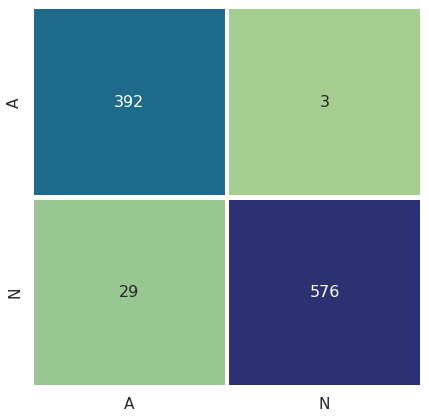

In [ ]:
plotConfusionMatrix(preds_dtw_new, y_test)

In [ ]:
print('F1 score: ' + str(f1_score(preds_dtw_new, np.array(y_test))))

F1 score: 0.9729729729729729


We can see that although some of the values were now predicted correctly, the result did not change much. This can be attributed to the dataset itself - since the heartbeat data was interpolated to a common length of 140 units, it is possible that the heartbeats are already quite aligned, and therefore using such a complex method, instead of a simple euclidean distance might be an overkill. It might be useful when using a different dataset, such as [this one](https://www.kaggle.com/datasets/shayanfazeli/heartbeat) from Kaggle, where the data is only padded and not interpolated to have the same length. But then again, since the dynamic time warping takes such a long time, it might be better to spend the time preprocessing the data.

## Results
Overall, the autoencoder model performed the best, especially considering that the model's parameters have not been tuned at all, so it might be possible to obtain an even better result. Even though the F1 score was not so different from both Euclidean distance and dynamic time warping, the autoencoder scored a lot better predicting the abnormal heatbeats. Since the task is heartbeat anomaly detection, this can be of great importance. Also, in terms of time complexity, the autoencoder performed much better. Both the training and prediction took a few seconds, and while the Euclidean distance computation was also pretty quick, about 3 minutes for prediction of all 1000 samples, dynamic time warping took much more. This might be improved by not iterating over the testing samples, but vectorizing the operation somehow instead.